Device: cpu
Train / Test size: 60000 10000
[Recon] epoch 1/4  L2(train)=0.0504
[Recon] epoch 2/4  L2(train)=0.0422
[Recon] epoch 3/4  L2(train)=0.0394
[Recon] epoch 4/4  L2(train)=0.0377
[Recon] L2(test)=29.3606
[Seq-Clf] epoch 1/4  CE(train)=0.5941  Acc(train)=0.8056
[Seq-Clf] epoch 2/4  CE(train)=0.3779  Acc(train)=0.8737
[Seq-Clf] epoch 3/4  CE(train)=0.3409  Acc(train)=0.8863
[Seq-Clf] epoch 4/4  CE(train)=0.3224  Acc(train)=0.8903
[Seq-Clf] CE(test)=0.3312  Acc(test)=0.8867


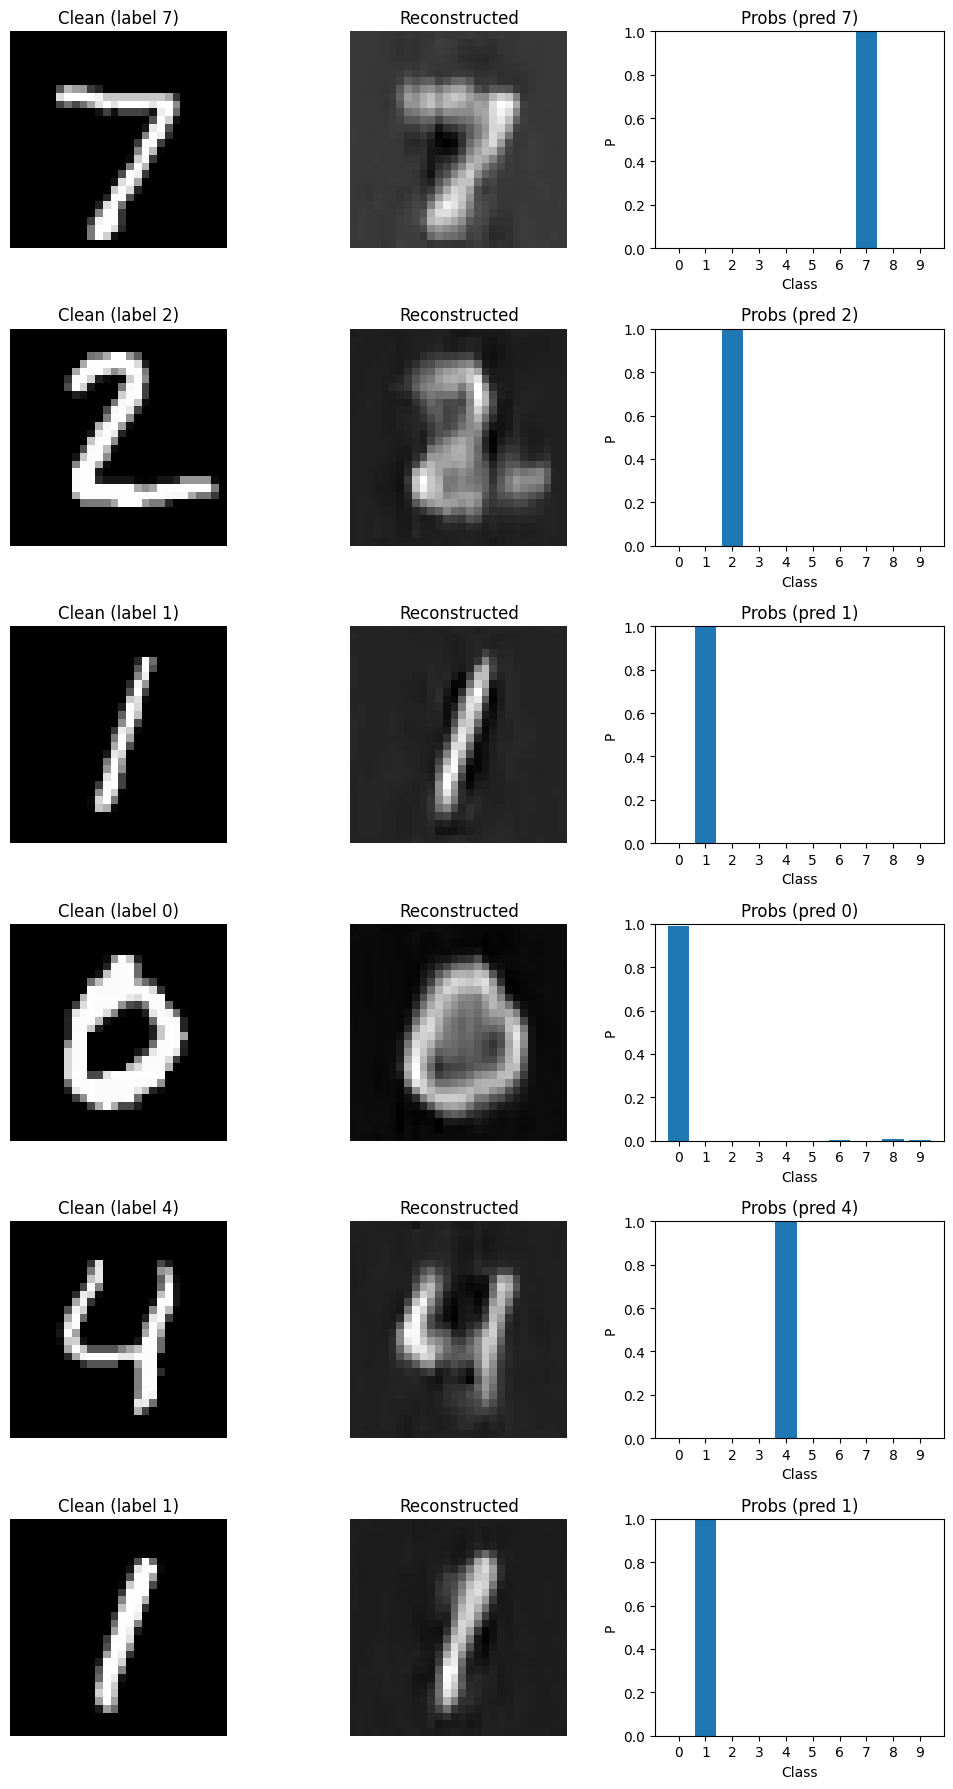

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from skimage.transform import radon   

SEED = 42
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

ANGLES = 5          
DETECTORS = 25      
I0 = 60.0           # photons/line (Poisson)
ANGLES_DEG = np.linspace(0.0, 180.0, ANGLES, endpoint=False)  

BATCH_SIZE = 128
EPOCHS_RECON = 4       
EPOCHS_SEQ_CLF = 4     
LR = 1e-3
DATA_DIR = "./data"
NUM_WORKERS = 0
PIN_MEMORY = False


# ---------- Forward model using scikit-image RADON ----------
def radon_counts_from_torch_images(x, I0=I0, angles_deg=ANGLES_DEG, out_detectors=DETECTORS):
    """
    Use skimage.transform.radon on each MNIST image to generate line integrals,
    then convert to Poisson photon counts via y ~ Poisson(I0 * exp(-s)).
    x: torch tensor [B,1,28,28] in [0,1]
    return: torch tensor y [B,1,ANGLES,out_detectors] (integer counts)
    """
    device = x.device
    B = x.shape[0]
    sinos = []

    # radon works on 2D numpy arrays; loop over the (tiny) MNIST batch
    for i in range(B):
        img = x[i, 0].detach().cpu().numpy()                    # [28,28], float
        sino = radon(img, theta=angles_deg, circle=False)       # array [D_raw, A]
        sinos.append(sino[None, ...])                           # [1, D_raw, A]

    s = np.stack(sinos, axis=0)                                 # [B, 1, D_raw, A]
    s_t = torch.from_numpy(s).to(device=device, dtype=torch.float32)

    # Reorder to [B,1,A,D_raw] and resample detectors -> out_detectors
    s_t = s_t.permute(0, 1, 3, 2)                               # [B,1,A,D_raw]
    s_t = F.interpolate(s_t, size=(s_t.shape[2], out_detectors),
                        mode="bilinear", align_corners=False)   # [B,1,A,D]

    # Beer–Lambert + Poisson counts
    with torch.no_grad():
        mu = I0 * torch.exp(-s_t).clamp(min=1e-8)
        y = torch.poisson(mu)                                   # integer counts
    return y                                                    # [B,1,A,D]

def log_transform(y, I0=I0, eps=1.0):
    """Approximate line integrals from counts: g = -log((y + eps)/I0)."""
    return -torch.log((y + eps) / I0)


# ---------- Dataset: generate (y, g, x, z) ----------
class TomoMNISTRadon(Dataset):
    """
    Each sample:
      y : [1,ANGLES,DETECTORS]  (Poisson counts)
      g : [1,ANGLES,DETECTORS]  (log-transformed counts)
      x : [1,28,28]             (clean MNIST image)
      z : int                   (label 0..9)
    """
    def __init__(self, root, train):
        self.mnist = torchvision.datasets.MNIST(
            root=root, train=train, download=True, transform=transforms.ToTensor()
        )

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        x, z = self.mnist[idx]                           # x: [1,28,28] in [0,1]
        y = radon_counts_from_torch_images(x.unsqueeze(0)).squeeze(0)  # [1,A,D]
        g = log_transform(y)                             # [1,A,D]
        return y, g, x, z


# ---------- Models ----------
class ReconNet(nn.Module):
    """
    Simple CNN reconstructor A† : [B,1,A,D] -> [B,1,28,28]
    (proxy for learned recon; trained with L2 to clean image)
    """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 64, 3, padding=1)
        self.up = nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False)
        self.c4 = nn.Conv2d(64, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, s):
        x = F.relu(self.c1(s))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = self.up(x)
        x = F.relu(self.c4(x))
        return self.out(x)  


class Classifier(nn.Module):
    """
    3 conv layers (32/64/128) each followed by 2x2 max-pool; dense to 10 logits.
    """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 3 * 3, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = self.pool(F.relu(self.c3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)  # logits (CrossEntropyLoss and softmax)


# ---------- DataLoaders ----------
train_ds = TomoMNISTRadon(DATA_DIR, train=True)
test_ds  = TomoMNISTRadon(DATA_DIR, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train / Test size:", len(train_ds), len(test_ds))


# ---------- Phase 1: pre-train reconstructor with L2 ----------
recon = ReconNet().to(DEVICE)
opt_recon = torch.optim.Adam(recon.parameters(), lr=LR)
l2 = nn.MSELoss()

for ep in range(EPOCHS_RECON):
    recon.train()
    running = 0.0
    for _, g, x, _ in train_loader:
        g, x = g.to(DEVICE), x.to(DEVICE)
        xhat = recon(g)
        loss = l2(xhat, x)
        opt_recon.zero_grad(); loss.backward(); opt_recon.step()
        running += loss.item() * x.size(0)
    print(f"[Recon] epoch {ep+1}/{EPOCHS_RECON}  L2(train)={running/len(train_ds):.4f}")


recon.eval()
tot = 0.0
with torch.no_grad():
    for _, g, x, _ in test_loader:
        g, x = g.to(DEVICE), x.to(DEVICE)
        tot += F.mse_loss(recon(g), x, reduction="sum").item()
print(f"[Recon] L2(test)={tot/len(test_ds):.4f}")


# ---------- Phase 2: sequential classifier training on reconstructions ----------
for p in recon.parameters():
    p.requires_grad = False
recon.eval()

clf = Classifier().to(DEVICE)
opt_clf = torch.optim.Adam(clf.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()

for ep in range(EPOCHS_SEQ_CLF):
    clf.train()
    sum_loss, correct, n = 0.0, 0, 0
    for _, g, _, z in train_loader:
        g, z = g.to(DEVICE), z.to(DEVICE)
        with torch.no_grad():
            xhat = recon(g)           
        logits = clf(xhat)
        loss = ce(logits, z)

        opt_clf.zero_grad(); loss.backward(); opt_clf.step()

        sum_loss += loss.item() * z.size(0)
        correct  += (logits.argmax(1) == z).float().sum().item()
        n += z.numel()
    print(f"[Seq-Clf] epoch {ep+1}/{EPOCHS_SEQ_CLF}  CE(train)={sum_loss/len(train_ds):.4f}  Acc(train)={correct/n:.4f}")

# test eval
clf.eval()
tot_ce, correct, n = 0.0, 0, 0
with torch.no_grad():
    for _, g, _, z in test_loader:
        g, z = g.to(DEVICE), z.to(DEVICE)
        xhat = recon(g)
        logits = clf(xhat)
        tot_ce += ce(logits, z).item() * z.size(0)
        correct += (logits.argmax(1) == z).float().sum().item()
        n += z.numel()
print(f"[Seq-Clf] CE(test)={tot_ce/len(test_ds):.4f}  Acc(test)={correct/n:.4f}")


# ---------- Visualization: clean vs reconstructed + probabilities ----------
def visualize_clean_recon_and_probs(recon, clf, loader, device, n_samples=6):
    recon.eval(); clf.eval()

    _, g, x, z = next(iter(loader))
    g, x, z = g.to(device), x.to(device), z.to(device)

    with torch.no_grad():
        xhat   = recon(g)
        logits = clf(xhat)
        probs  = torch.softmax(logits, dim=1)

    x_np     = x[:n_samples].cpu().numpy()
    xhat_np  = xhat[:n_samples].cpu().numpy()
    z_np     = z[:n_samples].cpu().numpy()
    probs_np = probs[:n_samples].cpu().numpy()

    n = x_np.shape[0]
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))
    if n == 1: axes = np.array([axes])

    for i in range(n):
        axes[i, 0].imshow(x_np[i, 0], cmap="gray", vmin=0, vmax=1)
        axes[i, 0].set_title(f"Clean (label {z_np[i]})"); axes[i, 0].axis("off")

        axes[i, 1].imshow(xhat_np[i, 0], cmap="gray")
        axes[i, 1].set_title("Reconstructed"); axes[i, 1].axis("off")

        axes[i, 2].bar(np.arange(10), probs_np[i])
        pred = probs_np[i].argmax()
        axes[i, 2].set_xticks(np.arange(10)); axes[i, 2].set_ylim(0, 1)
        axes[i, 2].set_title(f"Probs (pred {pred})"); axes[i, 2].set_xlabel("Class"); axes[i, 2].set_ylabel("P")

    plt.tight_layout(); plt.show()

visualize_clean_recon_and_probs(recon, clf, test_loader, DEVICE, n_samples=6)
